# Pipline for satellite image prediction an coordinate retrieval

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import os
import rasterio

from google.cloud import storage
from ultralytics import YOLO
from utils.geo_utils import get_true_pixel, list_of_ships_and_coords
from utils.image_processing import stretch_image, split_image
from utils.utils import download_image
from rasterio.plot import show

In [2]:
client = storage.Client()
bucket = client.get_bucket(os.environ['DV_BUCKET'])

## list all .tif files in the gc bucket

In [ ]:
# client = storage.Client()
# bucket = client.get_bucket(os.environ['DV_BUCKET'])

# # list files in gc bucket
# for blob in bucket.list_blobs():
#     if blob.name.endswith('.tif'):
#         print(blob.name)

## dowloading image from gc bucket

In [5]:
# filename = 'S1A_IW_GRDH_1SDV_20230215T034337_20230215T034402_047241_05AB34_5434_RES_10_NOT_CORRECTED.tif'
filename = (
    'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20230215T162338_20230215T162403_047249_05AB7F_600C0000000000-0000000000.tif'
)

In [6]:
with rasterio.open(download_image(filename), 'r') as f:
    img = stretch_image(f.read(1), -30, 0)
img.shape

(21698, 23296)

In [7]:
21698 * 23296

505476608

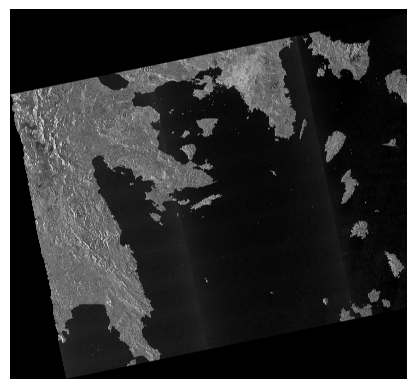

In [8]:
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## splitting images into [640,640] tiles

In [9]:
tiles = split_image(img)

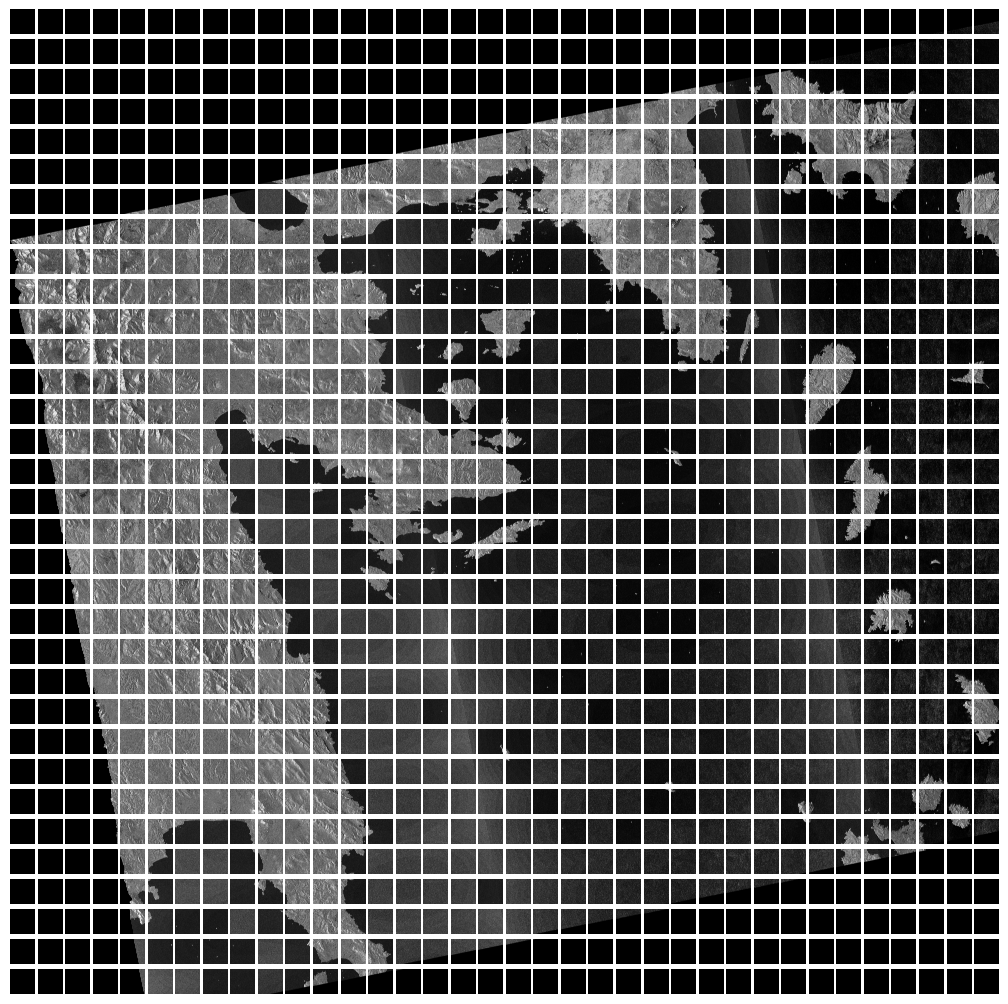

In [10]:
# get max number of tiles
n_rows, n_columns = int(np.floor(img.shape[0] / 640)), int(np.floor(img.shape[1] / 640))

# plot tiles
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10, 10))

for i in range(n_rows):
    for j in range(n_columns):
        axes[i, j].imshow(tiles[i][j], cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
plt.show()

In [11]:
tiles.shape

(33, 36, 640, 640)

## converting to RGB and putting them into a list to pass to YOLO


# <span style="color:blue"> **TODO**</span>

In [12]:
#### TODO: lets think about doing just one channel

# converting to RGB and putting them into a list to pass to YOLO
tiles_list = [np.dstack([tiles[i][j], tiles[i][j], tiles[i][j]]) for i in range(n_rows) for j in range(n_columns)]

# tiles_list = [tiles[i][j] for i in range(n_rows) for j in range(n_columns)]

len(tiles_list)

1188

In [13]:
from ultralytics import YOLO

weights_path = 'runs/detect/train4/weights/best.torchscript'

model = YOLO(weights_path)

# predicting

In [14]:
batch_size = 128
print(f'Number of batches: {len(tiles_list) // batch_size + 1}')

Number of batches: 10


In [ ]:
# batching the tiles_list and do the training
results = []
for i in range(len(tiles_list) // batch_size):
    results.extend(model(tiles_list[i * batch_size : (i + 1) * batch_size]))

# predicting the last batch
results.extend(model(tiles_list[(i + 1) * batch_size :]))

## view prediction

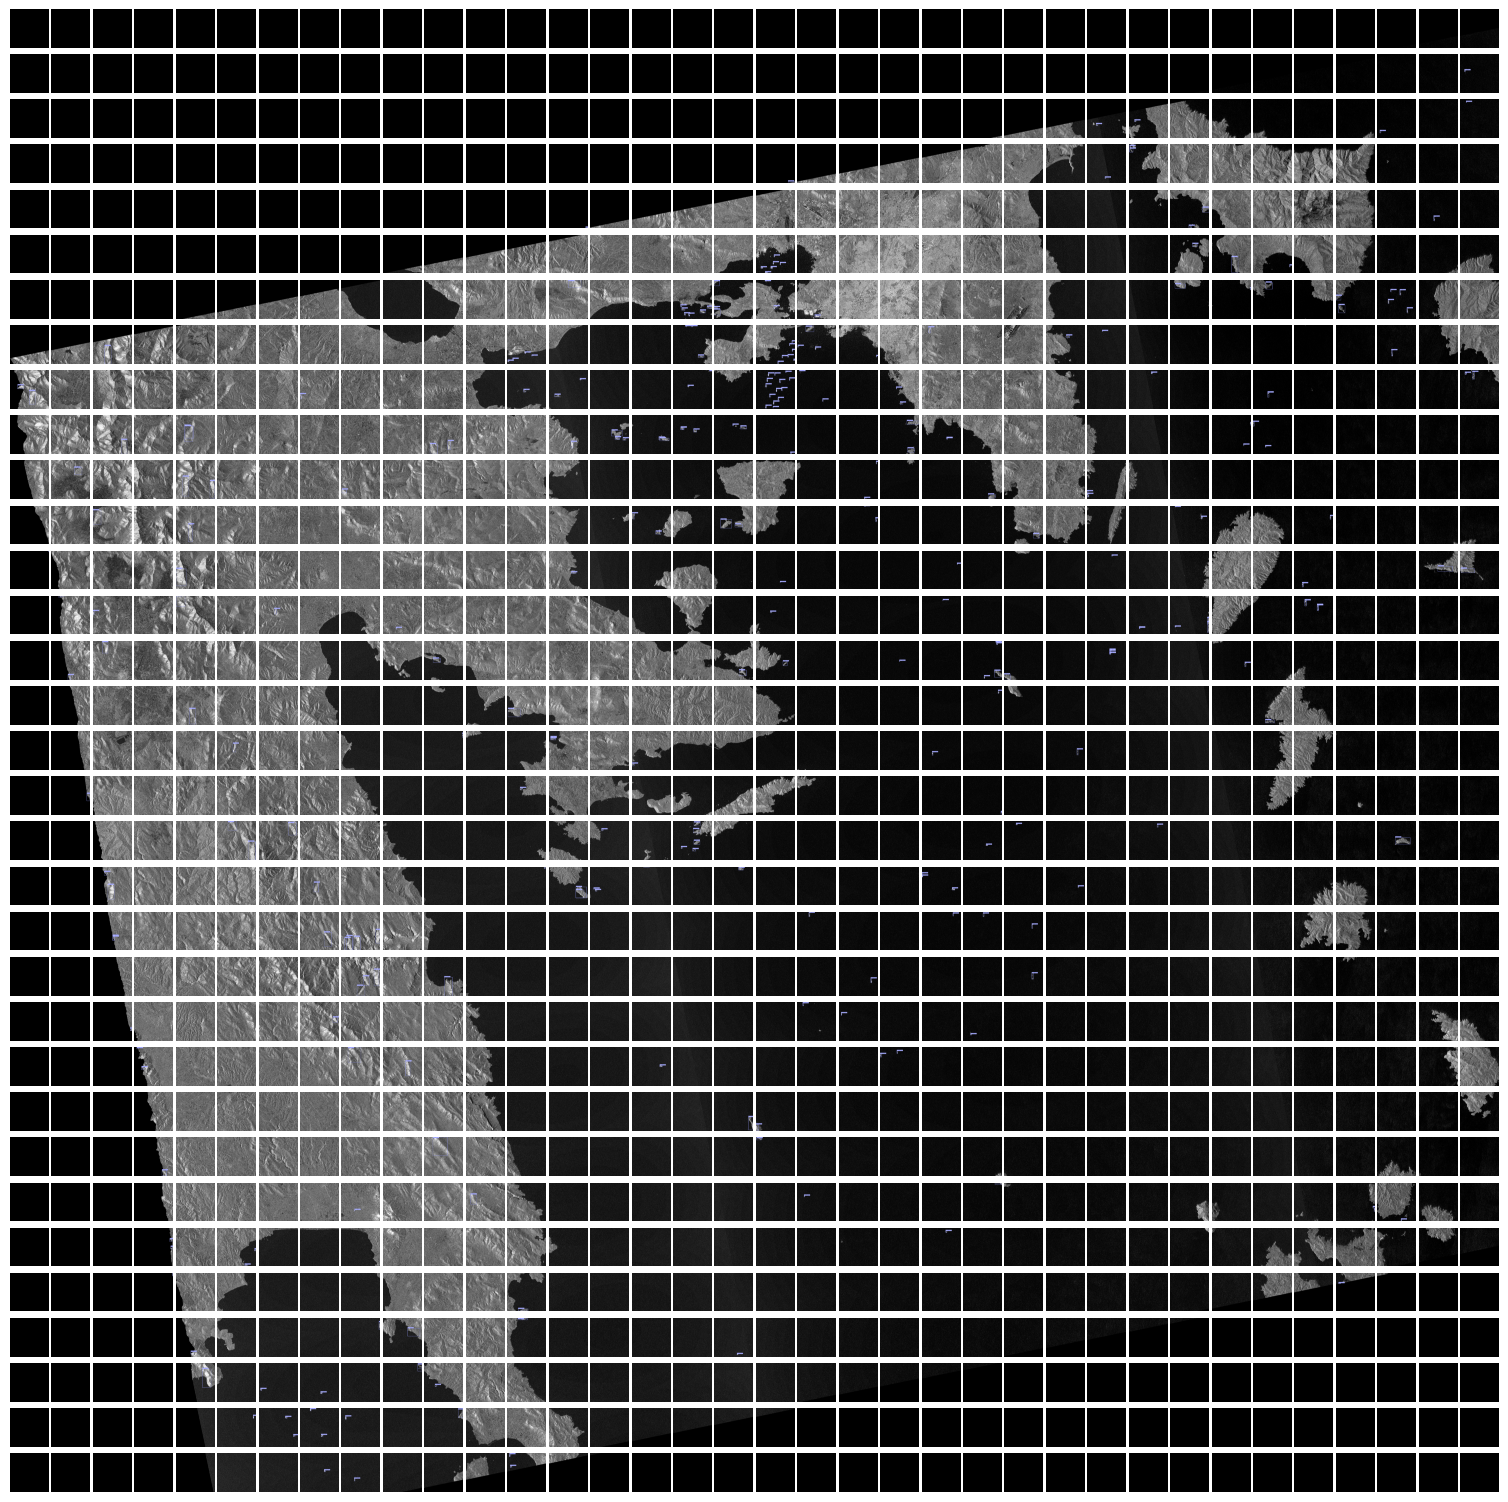

In [16]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, 15))

for i in range(n_rows):
    for j in range(n_columns):
        axes[i, j].imshow(results[i * n_columns + j].plot())
        axes[i, j].axis('off')

plt.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
plt.show()

## get coordinates of all predictions and save them to file

In [18]:
sar_img = rasterio.open(download_image(filename))

# Define the source and target CRS
# TODO: takes too long --> do while loading & save to file

source_crs = pyproj.CRS(sar_img.crs)
target_crs = pyproj.CRS("EPSG:4326")  # WGS84   EPSG:4326

# Create a transformer object
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

In [20]:
ships_and_coords = list_of_ships_and_coords(results, sar_img, n_columns, transformer)

In [21]:
import pandas as pd

csv_name = filename.split('/')[-1].split('.')[0]
pred_df = pd.DataFrame(ships_and_coords)
pred_df.to_csv(f'data/{csv_name}.csv', index=False)